In [ ]:
!pip install ultralytics torch torchvision matplotlib scikit-learn


^C
Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
from ultralytics import YOLO
import torchvision.transforms as transforms
from torchvision.models import resnet18
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import torch.nn as nn


In [6]:
class ComplexCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(ComplexCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512 * 8 * 8, 4096),  # Update this line
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.classifier(x)
        return x


In [13]:
# Load YOLOv8 model

yolo_model = YOLO('./UnderwaterDrone/Model/Model2-300.pt')

# Load CNN model
cnn_model = torch.load('./UnderwaterDrone/Model/cnn_model.pth',map_location=torch.device('cpu'))
cnn_model.eval()

# Use CUDA if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_model = cnn_model.to(device)

In [14]:
import cv2
import torch
from torchvision import transforms
from PIL import Image
import os

# Define video path
video_path = './UnderwaterDrone/Copy of Vid 3.1.mp4'

# Set up transformations for CNN
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Ensure this matches your model's input size
    transforms.ToTensor()
])

# Define colors for different classes
colors = {
    'gracillaria': (0, 0, 255),  # Red
    'linnaeus': (0, 255, 0)     # Green
}

# Frame interval for processing (e.g., process every 10th frame)
frame_interval = 100

# Function to plot and save results
def plot_save_image(image, boxes, labels, output_path):
    for box, label in zip(boxes, labels):
        x1, y1, x2, y2 = [int(coord) for coord in box]
        label = label.lower()
        color = colors.get(label)  # Default to white if label not in colors

        # Draw the rectangle with the specified color
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

        # Draw the label with larger text
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color, 2)

    cv2.imwrite(output_path, image)

# Create results directory if it doesn't exist
os.makedirs('results', exist_ok=True)

# Load the model and set to evaluation mode
cnn_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model.to(device)

# Process video
cap = cv2.VideoCapture(video_path)
all_labels, all_preds = [], []

frame_num = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Process every 'frame_interval' frame
    if frame_num % frame_interval == 0:
        # YOLOv8 inference
        yolo_results = yolo_model(frame)

        # Process YOLO results
        for result in yolo_results:
            if result.boxes is not None:
                for box in result.boxes:
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
                    crop = frame[y1:y2, x1:x2]

                    # Ensure the crop is not empty
                    if crop.size == 0:
                        continue

                    # Apply CNN for classification
                    crop_pil = Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
                    crop_tensor = transform(crop_pil).unsqueeze(0).to(device)

                    with torch.no_grad():
                        output = cnn_model(crop_tensor)
                        _, predicted = torch.max(output, 1)
                        label = 'Gracillaria' if predicted.item() == 0 else 'Linnaeus'

                    # Store labels and predictions for evaluation
                    detected_class_id = int(box.cls[0].cpu().numpy()) if box.cls is not None else None

                    # Assume 'names' attribute is a dictionary mapping class IDs to names
                    detected_label = yolo_model.names[detected_class_id] if detected_class_id is not None and detected_class_id < len(yolo_model.names) else 'unknown'

                    all_labels.append(detected_label)
                    all_preds.append(label)

                    # Save or plot results
                    plot_save_image(frame, [[x1, y1, x2, y2]], [label], f'results/frame_{frame_num}.jpg')

    frame_num += 1

cap.release()



0: 352x640 (no detections), 737.8ms
Speed: 81.1ms preprocess, 737.8ms inference, 12.0ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 4 Gracillarias, 3 Linnaeuss, 204.8ms
Speed: 4.0ms preprocess, 204.8ms inference, 21.6ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 2 Gracillarias, 192.3ms
Speed: 3.4ms preprocess, 192.3ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 Gracillaria, 252.6ms
Speed: 6.0ms preprocess, 252.6ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 Gracillaria, 7 Linnaeuss, 180.3ms
Speed: 2.0ms preprocess, 180.3ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 (no detections), 181.1ms
Speed: 2.0ms preprocess, 181.1ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 2 Gracillarias, 1 Linnaeus, 192.3ms
Speed: 3.0ms preprocess, 192.3ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 Gracill

Unique Labels: {'Gracillaria', 'Linnaeus'}
Unique Predictions: {'Gracillaria', 'Linnaeus'}


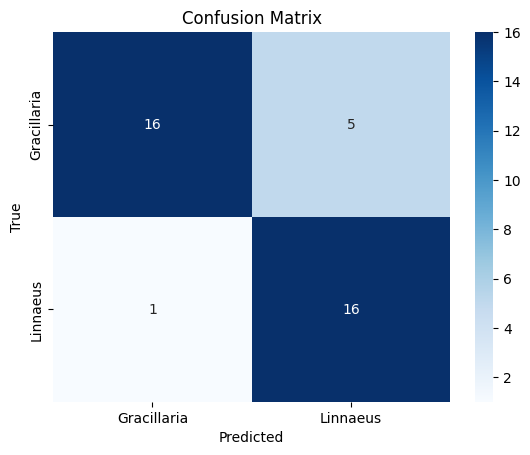

              precision    recall  f1-score   support

 Gracillaria       0.94      0.76      0.84        21
    Linnaeus       0.76      0.94      0.84        17

    accuracy                           0.84        38
   macro avg       0.85      0.85      0.84        38
weighted avg       0.86      0.84      0.84        38



In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Check unique labels and predictions
unique_labels = set(all_labels)
unique_preds = set(all_preds)

print(f"Unique Labels: {unique_labels}")
print(f"Unique Predictions: {unique_preds}")

# Define classes
classes = ['Gracillaria','Linnaeus' ]

# Ensure all labels and predictions match the classes
all_labels_mapped = [label if label in classes else 'unknown' for label in all_labels]
all_preds_mapped = [pred if pred in classes else 'unknown' for pred in all_preds]

# Confusion Matrix
cm = confusion_matrix(all_labels_mapped, all_preds_mapped, labels=classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(all_labels_mapped, all_preds_mapped, target_names=classes, labels=classes))

